In [ ]:
from datetime import datetime
import json
import pandas as pd
import numpy as np
from utils.f_display_and_feedback import *
from algorithms_functions.f_pichunter_star import *
from algorithms_functions.f_polyquery_msed_logscale import *
from algorithms_functions.f_polyadic_sed import *
from utils.f_process_data import *
from algorithms_functions.f_rocchio import *
from algorithms_functions.f_svm import *
from utils.functions_similarity_metrics import *
from utils.f_process_data import *
import h5py
import tqdm 
import random
import pickle


In [2]:

def data_loading():
    """
    Load the data and create the main dataframes.
    """
    print("Loading data...")
    df_visione_mapping, df_query_judgment, df_complete, df_complete_unique_sorted, df_visione_mapping_query, shot_labels_query, queries = process_data(
        '/home/francescascotti/data/avsGT/avs_gt_visione_mapping.csv',
        '/home/francescascotti/data/avsGT/avs_gt_visione_mapping_query_judgment.csv',
        threshold_1=200, threshold_0=1400)
    print("Data loading complete.")
    return df_visione_mapping, df_query_judgment, df_complete, df_complete_unique_sorted, df_visione_mapping_query, shot_labels_query, queries

hdf5_file_path= '/home/francescascotti/dev/interfaccia/indexed_file.h5'
hdf5_file = h5py.File(hdf5_file_path, 'r')
features = hdf5_file['indexed_data/data'][:]
ids = hdf5_file['indexed_data/ids'][:]
hdf5_file.close()
      
# pickle load  /home/francescascotti/dev/interfaccia/indexed_data_logistic 
     
with open('/home/francescascotti/dev/interfaccia/indexed_data_logistic', 'rb') as file:
    features_logistic = pickle.load(file)
  
    
_, _, _, _, _, shot_labels_query, queries = data_loading()
features = pd.DataFrame(features).transpose()
features.columns = [id.decode() if isinstance(id, bytes) else id for id in ids]
features_logistic = pd.DataFrame(features_logistic).transpose()
features_logistic.columns = features.columns
rocchio_time, svm_time, pichunter_time, polyadic_time, polyquery_msed_logscale_time = [], [], [], [], []


Loading data...


/home/francescascotti/dev/interfaccia/f_process_data.py:11: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_visione_mapping = pd.read_csv(csv_mapping_path, dtype={'column_name': str})


Data loading complete.


In [3]:
lista_10_labeled_positive=[]
lista_10_labeled_negative=[]
lista_totale=[]
for query in queries: 
    sample_size = min(10000, len([el[0] for el in shot_labels_query.keys() if el[1] == query]))
    features_id_accepted = random.sample([el[0] for el in shot_labels_query.keys() if el[1] == query], sample_size)# stringhe
    
    positive_first_display = random.sample( [i for i in features_id_accepted if shot_labels_query[(i, query)] == 1], 5) # stringhe
    negative_first_display = random.sample( [i for i in features_id_accepted if shot_labels_query[(i, query)] ==0], 5) # stringhe
    lista_10_labeled_positive.append(positive_first_display )
    lista_10_labeled_negative.append(negative_first_display)
    lista_totale.append(positive_first_display + negative_first_display)



# Salva come JSON
with open('/home/francescascotti/dev/interfaccia/lista_10_labeled_positive.json', 'w') as f:
    json.dump(lista_10_labeled_positive, f)


with open('/home/francescascotti/dev/interfaccia/lista_10_labeled_negative.json', 'w') as f:
    json.dump(lista_10_labeled_negative, f)
    
count=0
duplicates=[]
ids_da_tenere=[]
for el in lista_totale:
    for aa in el :
        ids_da_tenere.append(aa)
        if aa not in duplicates:
            duplicates.append(aa)
        count+=1
#count
#len(duplicates)

dataset_800= features[ids_da_tenere]
target_columns = 10000
current_columns = len(dataset_800.columns)
columns_to_add = target_columns - current_columns

if columns_to_add > 0:

    new_features_ids = random.sample([el for el in features.columns if el not in dataset_800.columns], columns_to_add)
    new_features = features[new_features_ids]
  
    dataset_800 = pd.concat([dataset_800, new_features], axis=1)

dataset_800.to_csv('/home/francescascotti/dev/interfaccia/data_10000_df.csv', index=False)


Index(['03110-111', '06495-082', '03110-098', '01799-293', '01799-268',
       '00292-055', '04613-022', '01799-199', '00502-051', '01799-570',
       ...
       '14581-287', '08466-805', '17111-081', '09859-026', '15941-189',
       '12843-322', '17101-234', '00118-091', '07448-236', '09371-572'],
      dtype='object', length=10000)

In [4]:
queries=list(set(queries))
data_10000_df=pd.read_csv('/home/francescascotti/dev/interfaccia/data_10000_df.csv')
data_10000_df_logistic= features_logistic[data_10000_df.columns]
with open('/home/francescascotti/dev/interfaccia/lista_10_labeled_positive.json', 'r') as f:
    lista_10_labeled_positive = json.load(f)
with open('/home/francescascotti/dev/interfaccia/lista_10_labeled_negative.json', 'r') as f:
    lista_10_labeled_negative = json.load(f)
rocchio_time, svm_time, pichunter_time, pichunter_star_time,polyadic_sed_time, polyadic_msed_time = [], [], [], [], [],[]
for i in range(len(queries)):
    
    
    start_time = datetime.now()
    query=queries[i]
    seed = 42
    print("--------------------")
    print("Query: ", query)
    
    random.seed(seed)
    positive_first_display=lista_10_labeled_positive[i]
    negative_first_display=lista_10_labeled_negative[i]
    display_df_1= pd.concat([features[positive_first_display],features[negative_first_display]], axis=1)
    new_features_id = random.sample([el for el in features.columns],90)
    display_df_finale=pd.concat([display_df_1,features[new_features_id]], axis=1)
    display_df_final_logistic=features_logistic[display_df_finale.columns]
    if len(list(set(display_df_finale.columns))) != 100:
        print('errore')
    if len(list(set(data_10000_df.columns))) != 10000:
        print('errore')
    end_time = datetime.now()
    print("Data preparation time: ", end_time - start_time)
    print("--------------------")
    ### ROCCHIO#####
    _, _, _, time_of_search_rocchio, _, _ =rocchio_single_step(data_10000_df, display_df_finale, positive_first_display,
                                     negative_first_display, alpha=0.75, beta=1, gamma=0.75,
                                     fun_name="euclidean", initial_query=None)
   
    rocchio_time.append(time_of_search_rocchio)
   
    ##### SVM ##### 
    _, _, time_of_search_svm, _, _, _=svm_single_step(data_10000_df,display_df_finale, positive_first_display,negative_first_display,initial_scores=None,alpha=0.75, beta=0.25)
    svm_time.append(time_of_search_svm)
        ###PICHUNTER_STAR###
    _, _, time_of_search_pic_star, _, _ = pichunter_single_step(
        data_10000_df, display_df_finale, positive_first_display, negative_first_display,
        fun_name="softmin", initial_prob=0, temperature=82.10553
    )
    pichunter_star_time.append(time_of_search_pic_star)


    ###PICHUNTER###
    _, _, time_of_search_pic, _, _  = pichunter_single_step(
        data_10000_df, display_df_finale, positive_first_display, [],
        fun_name="softmin", initial_prob=0, temperature=82.10553
    )
    pichunter_time.append(time_of_search_pic)
    

   ###### POLYADIC SED ##### 
 
        
    _, _, _, _ ,time_of_search_sed,_,_= poly_sed_logscale_single_step(data_10000_df_logistic, display_df_final_logistic, 
                                                                                                positive_first_display, 
                                                                                                negative_first_display, 
                                                                                                precomputed_dict_initial=None, 
                                                                                                alpha=0.75, beta=1, gamma=0.75, 
                                                                                                initial_query=None, 
                                                                                                initial_scores=None,
                                                                                                entropy_dict=None)
    polyadic_sed_time.append(time_of_search_sed)
       
     ###### POLYADIC MSED ##### 
    _, _, _, _ ,time_of_search_msed,_,_= poly_msed_logscale_single_step(data_10000_df_logistic, display_df_final_logistic, 
                                                                                                positive_first_display, 
                                                                                                negative_first_display, 
                                                                                                precomputed_dict_initial=None, 
                                                                                                alpha=0.75, beta=1, gamma=0.75, 
                                                                                                initial_query=None, 
                                                                                                initial_scores=None,
                                                                                                entropy_dict=None)
      
    polyadic_msed_time.append(time_of_search_msed)

   
# with open('/home/francescascotti/dev/interfaccia/time_dict_pichunter.json', 'w') as file:
#     json.dump(time_dict_pichunter, file, indent=4)
#     file.write("\n")      
# with open('/home/francescascotti/dev/interfaccia/time_dict_svm.json', 'w') as file:
#     json.dump(time_dict_svm, file, indent=4)
#     file.write("\n")  

# with open('/home/francescascotti/dev/interfaccia/time_dict_rocchio.json', 'w') as file:
#     json.dump(time_dict_rocchio, file, indent=4)
#     file.write("\n")        
    


# with open('/home/francescascotti/dev/interfaccia/time_dict_polyadic2.json', 'w') as file:
#      json.dump(time_dict_sed_logscale, file, indent=4)
#      file.write("\n")   

# with open('/home/francescascotti/dev/interfaccia/time_dict_msed.json', 'w') as file:
#     json.dump(time_dict_msed_logscale, file, indent=4)
#     file.write("\n") 

--------------------
Query:  1591
Data preparation time:  0:00:00.133999
--------------------
--------------------
Query:  1592
Data preparation time:  0:00:00.122393
--------------------
--------------------
Query:  1593
Data preparation time:  0:00:00.121889
--------------------
--------------------
Query:  1594
Data preparation time:  0:00:00.122375
--------------------
--------------------
Query:  1595
Data preparation time:  0:00:00.122521
--------------------
--------------------
Query:  1597
Data preparation time:  0:00:00.121550
--------------------
--------------------
Query:  1598
Data preparation time:  0:00:00.122339
--------------------
--------------------
Query:  1599
Data preparation time:  0:00:00.121408
--------------------
--------------------
Query:  1600
Data preparation time:  0:00:00.121911
--------------------
--------------------
Query:  1601
Data preparation time:  0:00:00.125001
--------------------
--------------------
Query:  1602
Data preparation time:  0:

In [9]:
print('mean rocchio time:', np.mean(rocchio_time).total_seconds())
print('mean svm time:', np.mean(svm_time).total_seconds())
print('mean pichunter time:', np.mean(pichunter_time).total_seconds())
print('mean pichunter star time:', np.mean(pichunter_star_time).total_seconds())
print('mean polyadic sed time:', np.mean(polyadic_sed_time).total_seconds())
print('mean polyadic msed time:', np.mean(polyadic_msed_time).total_seconds())

mean rocchio time: 0.052747
mean svm time: 0.045806
mean pichunter time: 0.09063
mean pichunter star time: 0.095069
mean polyadic sed time: 2.819505
mean polyadic msed time: 2.763181


In [3]:
time_dict_sed_logscale
with open('/home/francescascotti/dev/interfaccia/time_dict_polyadic_optimized_2.json', 'w') as file:
      json.dump(time_dict_sed_logscale, file, indent=4)
      file.write("\n") 

In [8]:
# find the difference between two lists
difference = list(set(display_old) - set(display_new))
difference

['07498-072',
 '08230-095',
 '01727-191',
 '12421-216',
 '03986-014',
 '10737-048',
 '10235-060',
 '06140-047',
 '05895-043',
 '04439-081',
 '08200-005',
 '14704-051',
 '10139-161',
 '10652-071',
 '09268-0444']

In [3]:
with open('/home/francescascotti/dev/interfaccia/time_dict_polyadic.json', 'w') as file:
    json.dump(time_dict_msed_logscale, file, indent=4)
    file.write("\n")   


In [20]:
time_dict_polyadic = {'method': 'Polyadic', 'total_time_poly_score': total_time_poly_score_l,
                    'total_time_get_matrix_relevant': total_time_get_matrix_relevant_l,
                    'time_sed': time_sed_l,
                    'total_time_sed_matrix':  total_time_sed_matrix_l,
                    'total_time_get_matrix_nonrelevant': total_time_get_matrix_nonrelevant_l ,
                    'time_display': time_display_l,
                    'total_time': total_time_l}

In [21]:

with open('/home/francescascotti/dev/interfaccia/time_dict_polyadic.json', 'w') as file:
    json.dump(time_dict_polyadic, file, indent=4)
    file.write("\n")  

# grafici e statistiche finali 

In [9]:
import json

# Define the file paths
pichunter_path = '/home/francescascotti/dev/interfaccia/time_dict_pichunter.json'
svm_path = '/home/francescascotti/dev/interfaccia/time_dict_svm.json'
rocchio_path = '/home/francescascotti/dev/interfaccia/time_dict_rocchio.json'
polyadic_jsd_path = '/home/francescascotti/dev/interfaccia/time_dict_polyadic2.json'
polyadic_sed_new='/home/francescascotti/dev/interfaccia/time_dict_polyadic_optimized_2.json'
msed_path = '/home/francescascotti/dev/interfaccia/time_dict_msed.json'
poly_original='/home/francescascotti/dev/interfaccia/time_dict_new_poly.json'
sed_optimized_path='/home/francescascotti/dev/interfaccia/time_dict_polyadic_optimized.json'

# Load each dictionary
with open(poly_original, 'r') as file:
    time_dict_polyadic = json.load(file)
    
with open(sed_optimized_path, 'r') as file:
    time_dict_sed_logscale = json.load(file)
with open(pichunter_path, 'r') as file:
    time_dict_pichunter = json.load(file)

with open(svm_path, 'r') as file:
    time_dict_svm = json.load(file)

with open(rocchio_path, 'r') as file:
    time_dict_rocchio = json.load(file)

with open(polyadic_sed_new, 'r') as file:
    time_dict_polyadic_sed_new= json.load(file)

with open(polyadic_jsd_path, 'r') as file:
    time_dict_polyadic_jsd = json.load(file)
with open(msed_path, 'r') as file:
    time_dict_msed_logscale = json.load(file)

# Use the dictionaries as needed
print(time_dict_pichunter)  # Example usage


{'method': 'Pichunter', 'total_time_single_step': [0.085047, 0.094468, 0.094531, 0.084476, 0.115944, 0.107176, 0.0948, 0.094616, 0.094399, 0.094756, 0.093069, 0.093295, 0.090825, 0.102266, 0.084708, 0.088938, 0.087797, 0.094734, 0.094075, 0.084627, 0.094637, 0.094141, 0.093173, 0.093882, 0.087876, 0.11478, 0.092686, 0.151744, 0.096257, 0.094068, 0.135869, 0.086095, 0.088462, 0.089274, 0.087706, 0.109772, 0.084037, 0.112194, 0.088556, 0.10232, 0.083808, 0.092118, 0.099914, 0.122635, 0.09455, 0.094047, 0.095166, 0.093041, 0.093944, 0.093944, 0.093836, 0.094321, 0.093812, 0.084186, 0.083888, 0.092555, 0.093939, 0.084407, 0.094107, 0.094513, 0.084037, 0.094353, 0.094587, 0.094637, 0.088255, 0.093152, 0.084179, 0.088174, 0.088977, 0.094371, 0.083762, 0.12554, 0.087149, 0.089851, 0.089561, 0.084131, 0.084343, 0.085126, 0.089958, 0.089004], 'time_display': [0.035301, 0.034849, 0.035095, 0.035177, 0.035015, 0.035221, 0.035407, 0.03528, 0.035755, 0.035227, 0.035252, 0.035017, 0.036111, 0.035448

In [10]:
dict_mean_sed_logscale={}
for el in time_dict_sed_logscale.keys():
    if el != 'method':
        dict_mean_sed_logscale[el]=np.mean(time_dict_sed_logscale[el])
dict_mean_pichunter={}
for el in time_dict_pichunter.keys():
    if el != 'method':
        dict_mean_pichunter[el]=np.mean(time_dict_pichunter[el])

dict_mean_rocchio={}
for el in time_dict_rocchio.keys():
    if el != 'method':
        dict_mean_rocchio[el]=np.mean(time_dict_rocchio[el])
dict_mean_svm={}    
for el in time_dict_svm.keys():
    if el != 'method':
        dict_mean_svm[el]=np.mean(time_dict_svm[el])
dict_mean_polyadic_sed_new={}
for el in time_dict_polyadic_sed_new.keys():
    if el != 'method':
        dict_mean_polyadic_sed_new[el]=np.mean(time_dict_polyadic_sed_new[el])
dict_mean_polyadic_jsd={}
for el in time_dict_polyadic_jsd.keys():
    if el != 'method':
        dict_mean_polyadic_jsd[el]=np.mean(time_dict_polyadic_jsd[el])
        
dict_mean_msed_logscale={}
for el in time_dict_msed_logscale.keys():
    if el != 'method':
        dict_mean_msed_logscale[el]=np.mean(time_dict_msed_logscale[el])
dict_mean_polyadic={}
for el in time_dict_polyadic.keys():
    if el != 'method':
        dict_mean_polyadic[el]=np.mean(time_dict_polyadic[el])


In [11]:
dict_mean_polyadic


{'total_time_sed_relevant': 5.9262500000000004e-05,
 'complexity_time_avg': 3.25e-07,
 'complexity_time_x': 3.1249999999999997e-07,
 'complexity_time_y': 2.624999999999999e-07,
 'total_time_score_relevant': 0.6070020749999999,
 'total_time_sed_non_relevant': 5.8987500000000004e-05,
 'complexity_time_avg_non_relevant': 4.6249999999999997e-07,
 'complexity_time_x2': 2.125e-07,
 'complexity_time_y2': 2.75e-07,
 'total_time_score_non_relevant': 0.60372975,
 'total_time_single_step': 1.2306528125000002}

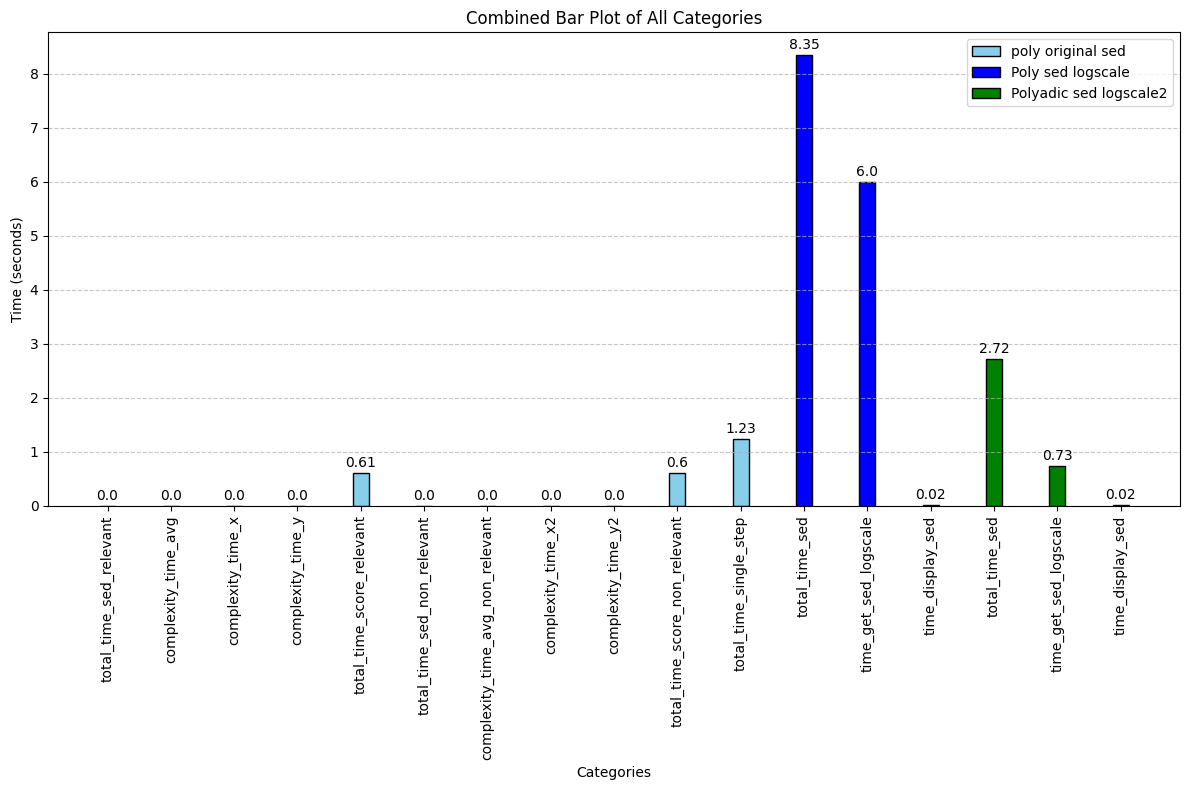

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming dict_mean_polyadic is defined elsewhere in your code
# For example:
categories_msed = list(dict_mean_polyadic.keys())
values_msed = list(dict_mean_polyadic.values())

categories_polyadic = list(dict_mean_sed_logscale.keys())
values_polyadic = list(dict_mean_sed_logscale.values())

categories_polyadic_additional = list(dict_mean_polyadic_sed_new.keys())
values_polyadic_additional = list(dict_mean_polyadic_sed_new.values())

# Create a combined list of categories and values
combined_categories = categories_msed + categories_polyadic + categories_polyadic_additional
combined_values = values_msed + values_polyadic + values_polyadic_additional

# Set bar positions (this will offset the bars for each dataset)
bar_width = 0.25  # Adjust bar width for better spacing
x_positions_msed = np.arange(len(categories_msed))
x_positions_polyadic = np.arange(len(categories_msed), len(categories_msed) + len(categories_polyadic))
x_positions_polyadic_additional = np.arange(len(categories_msed) + len(categories_polyadic), len(combined_categories))

# Create the plot
plt.figure(figsize=(12, 8))

# Plot bars for each dataset
bars_msed = plt.bar(x_positions_msed, values_msed, width=bar_width, color='skyblue', edgecolor='black', label='poly original sed')
bars_polyadic = plt.bar(x_positions_polyadic, values_polyadic, width=bar_width, color='blue', edgecolor='black', label='Poly sed logscale')
bars_polyadic_additional = plt.bar(x_positions_polyadic_additional, values_polyadic_additional, width=bar_width, color='green', edgecolor='black', label='Polyadic sed logscale2')

# Add value labels on top of bars
for bar in bars_msed:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

for bar in bars_polyadic:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

for bar in bars_polyadic_additional:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

# Set the x-ticks to show all category names
plt.xticks(np.concatenate([x_positions_msed, x_positions_polyadic, x_positions_polyadic_additional]),
           combined_categories, rotation=90)

# Add titles and labels
plt.title("Combined Bar Plot of All Categories")
plt.xlabel("Categories")
plt.ylabel("Time (seconds)")

# Add legend
plt.legend()

# Display gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()


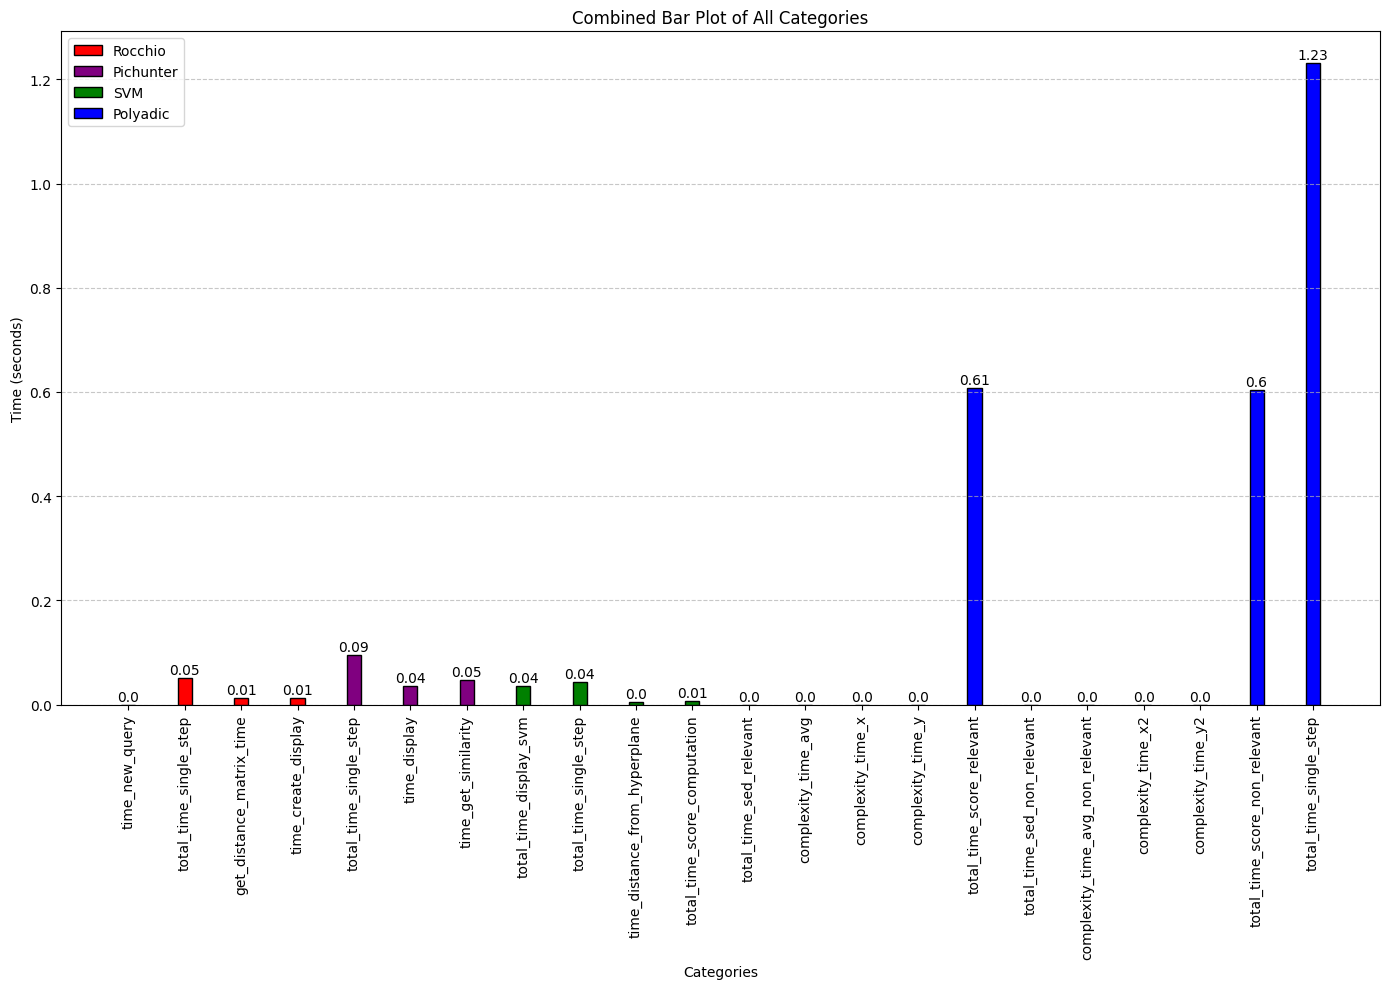

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming dict_mean_polyadic is defined elsewhere in your code
# For example:

# Merge data from all four dictionaries (including dict_mean_polyadic)
categories_rocchio = list(dict_mean_rocchio.keys())
values_rocchio = list(dict_mean_rocchio.values())

categories_pichunter = list(dict_mean_pichunter.keys())
values_pichunter = list(dict_mean_pichunter.values())

categories_svm = list(dict_mean_svm.keys())
values_svm = list(dict_mean_svm.values())

categories_polyadic = list(dict_mean_polyadic_sed.keys())
values_polyadic = list(dict_mean_polyadic_sed.values())

# Create a combined list of categories and values
combined_categories = categories_rocchio + categories_pichunter + categories_svm + categories_polyadic
combined_values = values_rocchio + values_pichunter + values_svm + values_polyadic

# Set bar positions (this will offset the bars for each dataset)
bar_width = 0.25  # Adjust bar width for better spacing
x_positions_rocchio = np.arange(len(categories_rocchio))
x_positions_pichunter = np.arange(len(categories_rocchio), len(categories_rocchio) + len(categories_pichunter))
x_positions_svm = np.arange(len(categories_rocchio) + len(categories_pichunter), len(categories_rocchio) + len(categories_pichunter) + len(categories_svm))
x_positions_polyadic = np.arange(len(categories_rocchio) + len(categories_pichunter) + len(categories_svm), len(combined_categories))

plt.figure(figsize=(14, 10))

# Plot bars for each dataset
bars_rocchio = plt.bar(x_positions_rocchio, values_rocchio, width=bar_width, color='red', edgecolor='black', label='Rocchio')
bars_pichunter = plt.bar(x_positions_pichunter, values_pichunter, width=bar_width, color='purple', edgecolor='black', label='Pichunter')
bars_svm = plt.bar(x_positions_svm, values_svm, width=bar_width, color='green', edgecolor='black', label='SVM')
bars_polyadic = plt.bar(x_positions_polyadic, values_polyadic, width=bar_width, color='blue', edgecolor='black', label='Polyadic')

# Add value labels on top of bars
for bar in bars_rocchio:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, round(yval, 2), ha='center', va='bottom')

for bar in bars_pichunter:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, round(yval, 2), ha='center', va='bottom')

for bar in bars_svm:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, round(yval, 2), ha='center', va='bottom')

for bar in bars_polyadic:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, round(yval, 2), ha='center', va='bottom')

# Set the x-ticks to show all category names
plt.xticks(np.concatenate([x_positions_rocchio, x_positions_pichunter, x_positions_svm, x_positions_polyadic]),
           combined_categories, rotation=90)

# Add titles and labels
plt.title("Combined Bar Plot of All Categories")
plt.xlabel("Categories")
plt.ylabel("Time (seconds)")

# Add legend
plt.legend()

# Display gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()
